In [1]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn 
assert sklearn.__version__ >= "0.20"

# common imports
import pandas as pd
import numpy as np 
import os 

# to plot pretty figures
%matplotlib inline 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from imutils import paths

# define lists of csv files
train_csvs = []
val_csvs = []
test_csvs = []

# loop over floors' ids
for i in [4, 5, 6]:
    # construct paths to train, validation, and test data
    train_paths = os.path.join("dataset", "{}".format(i), "train")
    val_paths = os.path.join("dataset", "{}".format(i), "val")
    test_paths = os.path.join("dataset", "{}".format(i), "test")
    
    # add paths to the csv files to the lists
    train_csvs += list(paths.list_files(train_paths, validExts="csv"))
    val_csvs += list(paths.list_files(val_paths, validExts="csv"))
    test_csvs += list(paths.list_files(test_paths, validExts="csv"))

print("# train : {}, val: {}, and test files: {}".format(len(train_csvs), len(val_csvs), len(test_csvs)))

# train : 61, val: 12, and test files: 18


In [3]:
# load the first csv file in the train set
# as an example
some_csv = pd.read_csv(train_csvs[0])
some_csv.head()

,0,1,2,3,4,5,6,7,8,9,...,gz,ax,ay,az,mx,my,mz,x,y,z
0,-37.0,-36.0,-36.0,-32.0,-33.0,-61.0,-52.0,-52.0,-70.0,-77.0,...,0.042150,-0.287304,9.370906,-2.770091,-11.040000,-56.399998,18.420000,0.016694,7.741971,1.801771
1,-37.0,-36.0,-36.0,-32.0,-33.0,-61.0,-52.0,-52.0,-70.0,-77.0,...,0.012828,0.356736,9.595961,-2.616862,-11.520000,-55.620000,18.359999,-0.008196,7.742290,1.801771
2,-37.0,-36.0,-36.0,-32.0,-33.0,-61.0,-52.0,-52.0,-70.0,-77.0,...,-0.036652,-0.047884,9.344569,-3.471592,-11.280000,-57.239998,19.560000,-0.033086,7.742609,1.801771
3,-37.0,-36.0,-36.0,-32.0,-33.0,-61.0,-52.0,-52.0,-70.0,-77.0,...,-0.014050,-0.318429,9.284714,-3.045425,-11.759999,-55.140000,18.660000,-0.057977,7.742928,1.801771
4,-37.0,-36.0,-36.0,-32.0,-33.0,-61.0,-52.0,-52.0,-70.0,-77.0,...,0.010996,0.371101,9.466674,-3.627216,-11.820000,-54.780000,18.480000,-0.082867,7.743247,1.801771


In [4]:
# function to calculate euclidean distance
# between predicted and target positions
def euclidean_distance(targets, preds):
    errors_all = []
    for pred, target in zip(preds, targets):
        # calculate the euclidean distance between
        # two vectors
        error_cur = np.linalg.norm(pred - target)
        # add the error to the list
        errors_all.append(error_cur)
    
    # return the mean error
    return np.mean(errors_all)

In [5]:
# function to construct a feature matrix and 
# target vector for training ML models
def build_x_y(csv_paths):
    # loop over the list of csv files
    for ind, csv_path in enumerate(csv_paths, 1):
        csv_data = pd.read_csv(csv_path).to_numpy()
        rows, cols = csv_data.shape
        
        # features and targets of the current file
        X_ind = csv_data[:, :220] # RSS signals
        X_ind[np.where(X_ind==0)] = -100.0
        y_ind = csv_data[:, -3:]  # xyz positions
        
        # downsample 
        for i in range(rows):
            if ind == 1 and i == 0:
                X = X_ind[i:i+1, :]
                y = y_ind[i:i+1, :]
                continue
            
            euc_dst = np.linalg.norm(X[-1, :] - X_ind[i, :]) 
            if euc_dst > 0:
                X = np.concatenate((X, X_ind[i:i+1, :]), axis=0)
                y = np.concatenate((y, y_ind[i:i+1, :]), axis=0)
            else:
                continue        
            
    return X, y

In [6]:
X_train, y_train = build_x_y(train_csvs)
X_train = (X_train.astype('float32') + 100.0) / 100.0

print(X_train.shape, y_train.shape)

(6049, 220) (6049, 3)


In [7]:
mean = np.mean(X_train)
std = np.std(X_train)

X_train_norm = (X_train - mean)

print(mean, std, np.mean(X_train_norm), np.max(X_train_norm), np.min(X_train_norm))

0.04096683 0.10514598 -9.961131e-10 0.7290332 -0.04096683


In [8]:
X_val, y_val = build_x_y(val_csvs)
X_val = (X_val.astype('float32') + 100.0) / 100.0
X_val_norm = (X_val - mean)

print(X_val.shape, y_val.shape)
print(np.mean(X_val_norm), np.max(X_val_norm), np.min(X_val_norm))

(1976, 220) (1976, 3)
0.00054736005 0.6990332 -0.04096683


In [9]:
X_test, y_test = build_x_y(test_csvs)
X_test = (X_test.astype('float32') + 100.0) / 100.0
X_test_norm = (X_test - mean)

print(X_test.shape, y_test.shape)

(2601, 220) (2601, 3)


In [10]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 150:
        lr = 1e-4
    elif epoch > 100:
        lr = 5e-4
    print('Learning rate: ', lr)
    return lr

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

In [24]:
# network parameters
input_size = X_train.shape[1]
epochs = 200
batch_size = 8
hidden_units = 128
dropout = 0.1

# model is a 3-layer MLP with ReLU and dropout after each layer
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               28288     
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [25]:
optimizer = Adam(lr=lr_schedule(0))
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])

# train the network
H = model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val), 
    batch_size=batch_size, 
    epochs=epochs,
    shuffle=True)

Learning rate:  0.001
Epoch 1/200
757/757 [==============================] - 1s 806us/step - mae: 3.9223 - loss: 46.0004 - val_loss: 8.5973 - val_mae: 2.0020
Epoch 2/200
757/757 [==============================] - 1s 812us/step - mae: 2.4703 - loss: 12.2850 - val_loss: 7.1504 - val_mae: 1.8579
Epoch 3/200
757/757 [==============================] - 1s 709us/step - mae: 2.2472 - loss: 10.3009 - val_loss: 7.4579 - val_mae: 1.8273
Epoch 4/200
757/757 [==============================] - 1s 716us/step - mae: 2.0980 - loss: 9.0553 - val_loss: 5.1220 - val_mae: 1.4596
Epoch 5/200
757/757 [==============================] - 1s 717us/step - mae: 2.0156 - loss: 8.3767 - val_loss: 6.4036 - val_mae: 1.7322
Epoch 6/200
757/757 [==============================] - 1s 750us/step - mae: 1.9211 - loss: 7.6477 - val_loss: 5.3090 - val_mae: 1.4909
Epoch 7/200
757/757 [==============================] - 1s 811us/step - mae: 1.8933 - loss: 7.4020 - val_loss: 4.2359 - val_mae: 1.3890
Epoch 8/200
757/757 [=========

757/757 [==============================] - 1s 876us/step - mae: 1.1180 - loss: 2.5986 - val_loss: 2.3154 - val_mae: 1.0303
Epoch 62/200
757/757 [==============================] - 1s 870us/step - mae: 1.1154 - loss: 2.6080 - val_loss: 1.8425 - val_mae: 0.8660
Epoch 63/200
757/757 [==============================] - 1s 882us/step - mae: 1.1145 - loss: 2.5336 - val_loss: 1.6846 - val_mae: 0.7740
Epoch 64/200
757/757 [==============================] - 1s 828us/step - mae: 1.1086 - loss: 2.5581 - val_loss: 1.6755 - val_mae: 0.7907
Epoch 65/200
757/757 [==============================] - 1s 847us/step - mae: 1.1080 - loss: 2.5548 - val_loss: 2.0492 - val_mae: 0.8567
Epoch 66/200
757/757 [==============================] - 1s 779us/step - mae: 1.1029 - loss: 2.5087 - val_loss: 1.6594 - val_mae: 0.8124
Epoch 67/200
757/757 [==============================] - 1s 790us/step - mae: 1.0929 - loss: 2.4763 - val_loss: 2.1997 - val_mae: 0.8931
Epoch 68/200
757/757 [==============================] - 1s 81

757/757 [==============================] - 1s 871us/step - mae: 0.9779 - loss: 1.9844 - val_loss: 1.5428 - val_mae: 0.7829
Epoch 122/200
757/757 [==============================] - 1s 889us/step - mae: 0.9857 - loss: 2.0307 - val_loss: 1.3554 - val_mae: 0.7004
Epoch 123/200
757/757 [==============================] - 1s 819us/step - mae: 0.9865 - loss: 2.0570 - val_loss: 1.6311 - val_mae: 0.7509
Epoch 124/200
757/757 [==============================] - 1s 799us/step - mae: 0.9715 - loss: 1.9565 - val_loss: 1.5322 - val_mae: 0.7521
Epoch 125/200
757/757 [==============================] - 1s 813us/step - mae: 0.9569 - loss: 1.8812 - val_loss: 1.3697 - val_mae: 0.6927
Epoch 126/200
757/757 [==============================] - 1s 789us/step - mae: 0.9561 - loss: 1.8711 - val_loss: 1.4012 - val_mae: 0.6955
Epoch 127/200
757/757 [==============================] - 1s 797us/step - mae: 0.9754 - loss: 1.9692 - val_loss: 1.4120 - val_mae: 0.7035
Epoch 128/200
757/757 [==============================] 

757/757 [==============================] - 1s 1ms/step - mae: 0.9087 - loss: 1.7301 - val_loss: 1.5057 - val_mae: 0.7201
Epoch 182/200
757/757 [==============================] - 1s 1ms/step - mae: 0.8932 - loss: 1.6404 - val_loss: 1.6648 - val_mae: 0.7626
Epoch 183/200
757/757 [==============================] - 1s 1ms/step - mae: 0.9218 - loss: 1.7739 - val_loss: 1.5596 - val_mae: 0.7625
Epoch 184/200
757/757 [==============================] - 1s 1ms/step - mae: 0.9077 - loss: 1.6788 - val_loss: 1.4554 - val_mae: 0.7172
Epoch 185/200
757/757 [==============================] - 1s 1ms/step - mae: 0.9191 - loss: 1.7354 - val_loss: 1.4908 - val_mae: 0.6989
Epoch 186/200
757/757 [==============================] - 1s 1ms/step - mae: 0.8956 - loss: 1.6548 - val_loss: 1.4423 - val_mae: 0.6913
Epoch 187/200
757/757 [==============================] - 1s 1ms/step - mae: 0.9131 - loss: 1.7145 - val_loss: 1.6149 - val_mae: 0.7382
Epoch 188/200
757/757 [==============================] - 1s 1ms/step 

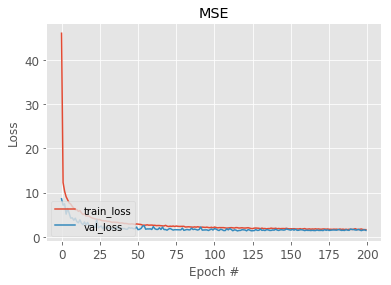

In [26]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.title("MSE")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

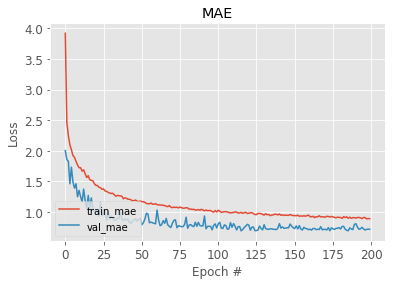

In [27]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["mae"], label="train_mae")
plt.plot(np.arange(0, epochs), H.history["val_mae"], label="val_mae")
plt.title("MAE")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [22]:
preds = model.predict(X_val_norm, batch_size=batch_size)
euclidean_distance(y_val, preds)

1.6476420380387324

In [23]:
preds = model.predict(X_test_norm, batch_size=batch_size)
euclidean_distance(y_test, preds)

1.6628582654856245